# DU-ISTA法 

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [34]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [35]:
n = 128
m = 64
σ = 0.1
p = 0.05
num_itr = 40

K = 200
adam_lr = 5e-5
max_inner = 20

A = randn(m, n)
γ_opt = 1.0/maximum(eigvals(A'*A))

0.0027906580479404633

### ミニバッチ生成関数 (スパースベクトル生成関数)

In [36]:
function mini_batch(K)
    seq = randn(n,K)
    support = zeros(n, K)
    for i in 1:n
        for j in 1:K
            if rand() < p
                support[i,j] = 1
            end
        end
    end
    x = seq .* support
    y = A*x + σ*randn(m,K)
    return y, x
end

mini_batch (generic function with 1 method)

In [37]:
@time y, xorg = mini_batch(K)

  0.086443 seconds (44.81 k allocations: 2.555 MiB, 95.19% compilation time)


([0.7905983573322826 -0.34017795710906357 … -0.6926718089497965 -0.16585542345258586; 1.349363808733962 -2.052793196136574 … -1.5813840565163062 0.13449425547308802; … ; 2.0468147004066988 -0.4099160792140992 … 0.5992500563469374 0.3488942081569392; 1.6876551921258829 0.8104278602210715 … -1.0776702737624606 0.592969243487986], [-0.0 0.0 … -0.0 0.0; 0.0 0.0 … -0.0 -0.0; … ; 0.0 -0.0 … 0.0 0.0; 0.0 0.0 … -0.0 -0.0])

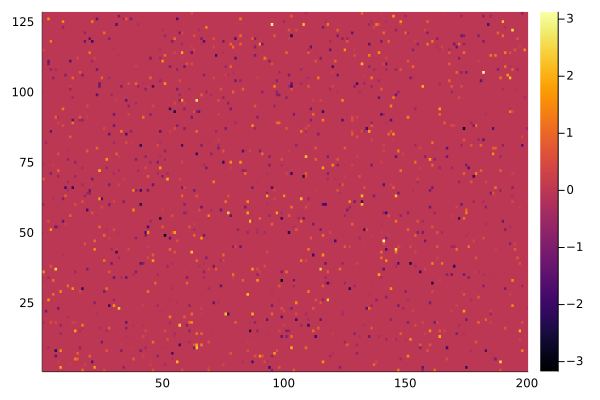

In [38]:
heatmap(xorg)

### ISTA法

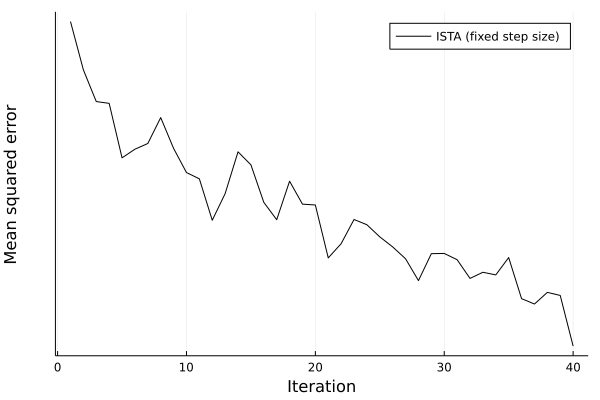

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/wadayama/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [39]:
function ISTA(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - γ_opt*A'*(A*x - y)
        x = softshrink.(x, γ_opt)
    end
    return x
end

function comp_mse(max_itr)
    y, x_org = mini_batch(K)
    x̂ = ISTA(max_itr, y)
    return norm(x_org - x̂)^2/K
end
        
ISTA_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, ISTA_mse, lw=1, yscale=:log10, label="ISTA (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-ISTA反復の定義 

In [40]:
function DU_ISTA(max_itr, y, eta, mu)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - eta[i]*A'*(A*x - y)
        x = softshrink.(x, mu[i])
    end
    return x
end

DU_ISTA (generic function with 1 method)

### 損失関数の定義

In [41]:
function loss(x_org, x̂)
    return norm(x_org - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [42]:
function train(opt, eta, mu)
    ps = Flux.params(eta, mu) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            y, x_org = mini_batch(K)
            gs = gradient(ps) do
                x_hat = DU_ISTA(itr, y, eta, mu)
                loss(x_org, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        y, x_org = mini_batch(K)
        x̂ = DU_ISTA(itr, y, eta, mu)
        println(itr, " ", loss(x_org, x̂))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [43]:
function comp_mse_DUGD(max_itr, eta, mu)
    y, x_org = mini_batch(K)
    x̂ = DU_ISTA(max_itr, y, eta, mu)
    return loss(x_org, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程

1 4.7683037700985285
2 3.590824588882076
3 3.5696276243976746
4 3.158691220872039
5 3.268199944116065
6 3.0052110995200936
7 2.7602243643172013
8 2.44184233551628
9 2.3743095722270326
10 2.1033562593335513
11 1.905159018723625
12 1.841534650977716
13 1.589253266354845
14 1.4962747993257912
15 1.3545821156190376
16 1.110493756665699
17 1.0503284646705073
18 0.9682631954509437
19 0.8213484922003569
20 0.7199797500280966
21 0.6032707510295426
22 0.5418409523882901
23 0.4966016730438374
24 0.537060042640542
25 0.4110346671514138
26 0.36163075471933676
27 0.37060198885254564
28 0.312720264083632
29 0.17339238711931226
30 0.23725761752415195
31 0.17068571311417105
32 0.14187178085568009
33 0.20139186920833116
34 0.13582886164776106
35 0.07690744212429275
36 0.12004080264201228
37 0.06343381501863607
38 0.08923192726648299
39 0.06264880013756378
40 0.06618657603112288


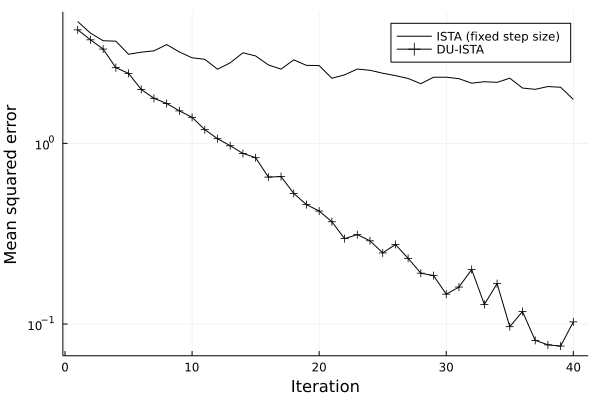

In [44]:
eta_train = γ_opt*ones(num_itr)
mu_train = γ_opt*ones(num_itr)
opt = ADAM(adam_lr)
train(opt, eta_train, mu_train)
DUGD_mse =[comp_mse_DUGD(i, eta_train, mu_train) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-ISTA", color=:black, marker=:+)

In [45]:
savefig("DU-ISTA.pdf")

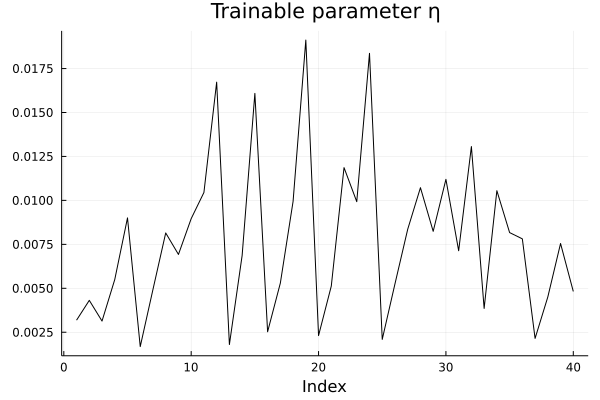

In [46]:
p1 = plot(1:num_itr, eta_train, xlabel="Index", color=:black, legend=false, title="Trainable parameter η")

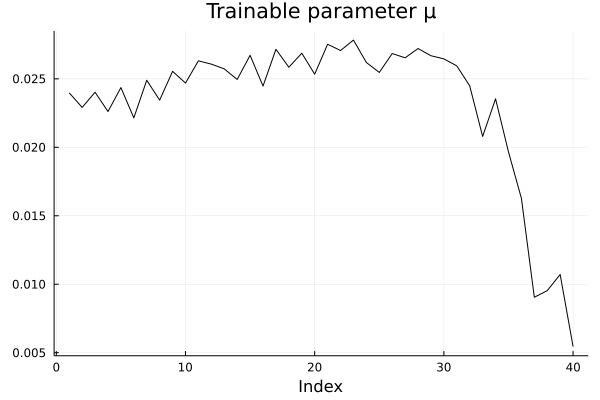

In [50]:
p2 = plot(1:num_itr, mu_train, xlabel="Index", color=:black, legend=false, title="Trainable parameter μ")

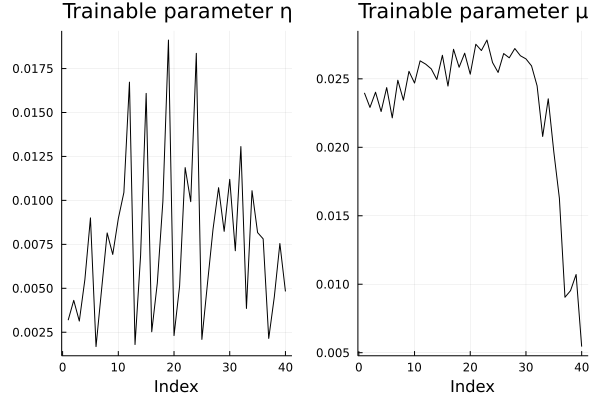

In [51]:
plot(p1,p2)

In [52]:
savefig("DU-ISTA-param.pdf")